<a href="https://colab.research.google.com/github/SaketMunda/time-series-with-tensorflow/blob/master/time_series_with_tensorflow_bitpredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 3: Time series forecasting in Tensorflow (BitPredict 💰📈)

The goal of this notebook is to get familiar working with Time series data.

We're going to be building a series of models in an attempt to predict the price of Bitcoin.

In [1]:
# check for gpu
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Get the data

To build a time series forecasting model, the first thing we're going to need is data.

So we're going to get the data of Bitcoin from some source like [Yahoo Finance](https://finance.yahoo.com/quote/BTC-USD/history?period1=1410912000&period2=1679356800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true) in csv format.

I've downloaded it in csv format and currently in the [github repo](https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD.csv).

Let's download it into the colab and view what it looks like.

In [2]:
!wget https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD.csv

--2023-03-28 02:35:22--  https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255951 (250K) [text/plain]
Saving to: ‘BTC-USD.csv’

BTC-USD.csv         100%[===================>] 249.95K  --.-KB/s    in 0.02s   

2023-03-28 02:35:22 (11.5 MB/s) - ‘BTC-USD.csv’ saved [255951/255951]



### Importing time series data with pandas

In [3]:
## read with pandas
import pandas as pd

df = pd.read_csv('/content/BTC-USD.csv', parse_dates=['Date'], index_col=['Date'])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-17,25055.123047,27787.812500,24955.169922,27423.929688,27423.929688,50730261335
2023-03-18,27448.117188,27725.953125,26636.261719,26965.878906,26965.878906,35723036817
2023-03-19,26969.503906,28440.560547,26907.716797,28038.675781,28038.675781,37769448859
2023-03-20,28041.601563,28527.724609,27242.880859,27767.236328,27767.236328,44774027664
2023-03-21,27784.175781,27980.882813,27737.007813,27964.888672,27964.888672,41356222464


So we have daily prices of Bitcoin from **17th Sept 2014** to **21st March 2023**, almost 8+ years

In [5]:
len(df)

3108

In [6]:
3108/365

8.515068493150684

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3108 entries, 2014-09-17 to 2023-03-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3108 non-null   float64
 1   High       3108 non-null   float64
 2   Low        3108 non-null   float64
 3   Close      3108 non-null   float64
 4   Adj Close  3108 non-null   float64
 5   Volume     3108 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 170.0 KB


Different types of Time Series Data

- **Trend**: time series has a clear long-term increase or decrease (may or may not be linear)
- **Seasonal**: time series affected by seasonal factors such as time of year (e.g increased sales towards end of year) or day of week
- **Cyclic**: time series shows rises and falls over an unfixed period, these tend to be longer/more variable than seasonal patterns

For more insights on various kinds of Time series data, please read [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html)

To simplify let's remove some of the columns from our data so we're only left with a date index and the closing price

In [8]:
bitcoin_prices = pd.DataFrame(df["Adj Close"]).rename(columns={"Adj Close":"Price"})
bitcoin_prices

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2023-03-17,27423.929688
2023-03-18,26965.878906
2023-03-19,28038.675781


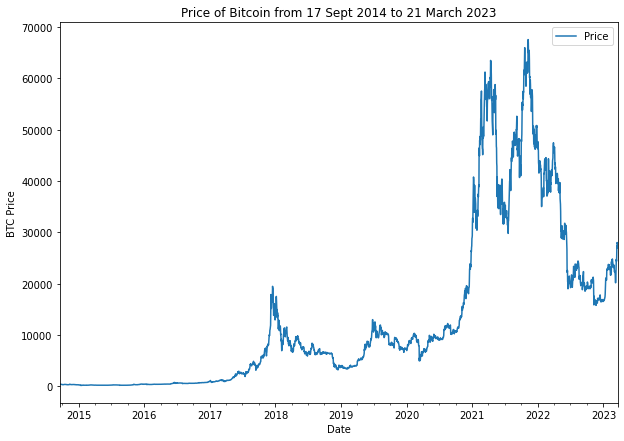

In [9]:
# let's plot everything
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.legend()
plt.title("Price of Bitcoin from 17 Sept 2014 to 21 March 2023");

### Importing time series data with Python's CSV module

In [10]:
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("/content/BTC-USD.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates as dates
    btc_price.append(float(line[5])) # get the adjusted closing price

# view first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2014, 9, 17, 0, 0),
  datetime.datetime(2014, 9, 18, 0, 0),
  datetime.datetime(2014, 9, 19, 0, 0),
  datetime.datetime(2014, 9, 20, 0, 0),
  datetime.datetime(2014, 9, 21, 0, 0),
  datetime.datetime(2014, 9, 22, 0, 0),
  datetime.datetime(2014, 9, 23, 0, 0),
  datetime.datetime(2014, 9, 24, 0, 0),
  datetime.datetime(2014, 9, 25, 0, 0),
  datetime.datetime(2014, 9, 26, 0, 0)],
 [457.334015,
  424.440002,
  394.79599,
  408.903992,
  398.821014,
  402.152008,
  435.790985,
  423.204987,
  411.574005,
  404.424988])

Let's plot this

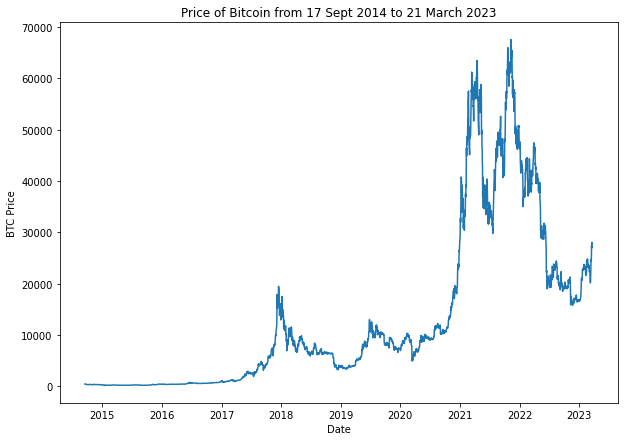

In [11]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.xlabel("Date")
plt.title("Price of Bitcoin from 17 Sept 2014 to 21 March 2023");

## Format Data Part 1 : Create train and test sets for Time Series data

Before we create splits we want to know what kind of data we have.

In time series problems, you'll either have **univariate** and **multivariate** data.

- Univariate time series data deals with one variable, for example using the price of bitcoin to predict the price of bitcoin
- Multivariate time series data deals with more than one variable, for example predicting the price of bitcoin using the price of bitcoin and block rewards and volume

### Create Train and Test sets for time series (wrong way)


In [12]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, prices, test_size=0.2, random_state=42)


X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2486,), (622,), (2486,), (622,))

Looks like the splits worked well, but let's not trust numbers on a page, visualize, visualize and visualize

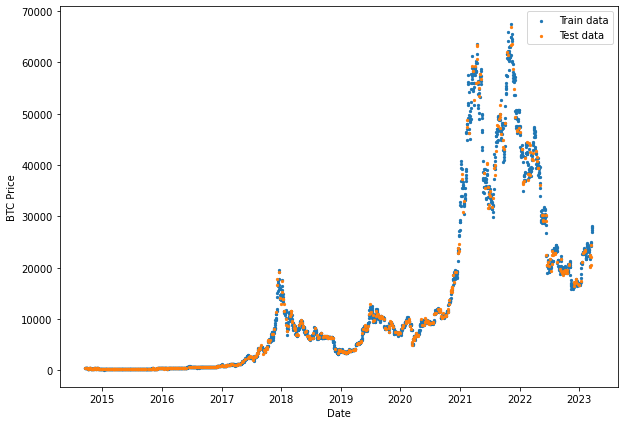

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.ylabel("BTC Price")
plt.xlabel("Date")
plt.legend();

Since this is a time component so the split should be continous, if there is no time component then random split will work but since we are going to forecast the future, then we need past data.

### Create Train and Test sets for time series (the right way)

In [14]:
split_size = int(0.8 * len(prices)) # 80% of train sets and 20% of test sets

X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]



Now if we visualize the plot,

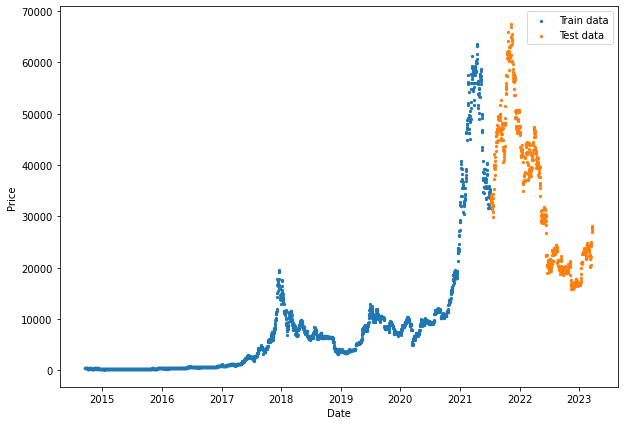

In [15]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend();

This is the correct way of splitting the data of time series problem. The plot should look like above.

### Creating a plotting function

Rather than retyping `matplotlib` commands to continously plot data, let's make a plotting function we can reuse later

In [16]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a time series plot on timesteps (a series of points in time) against values
  (a series of values across timesteps)

  Parameters
  ------------
  timesteps: array of timesteps
  values: array of values across time
  format: style of plot, default '.'
  start: where to start the plot
  end: where to end the plot
  label: label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

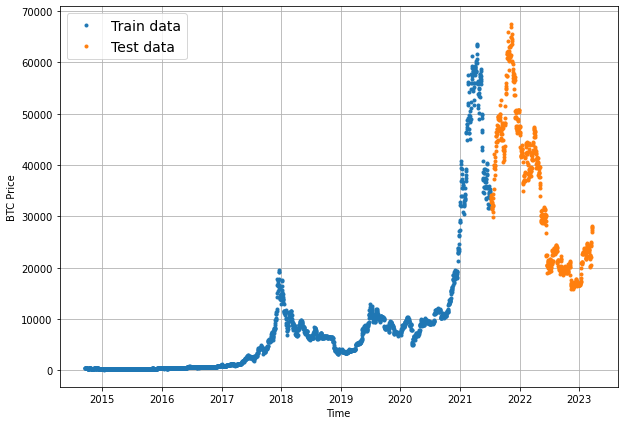

In [17]:
plt.figure(figsize=(10,7))
plot_time_series(X_train, y_train, label="Train data")
plot_time_series(X_test, y_test, label="Test data")

## Modelling Experiments

There are two terms that we should be familiar with, **horizon** and **window**,
- **horizon**: number of timesteps to predict into future
- **window**: number of timesteps from past used to predict **horizon**

For example, if we wanted to predict the price of Bitcoin for Tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and window would be 7.


List of modelling experiments we are going to perform,


| **Model Number** | **Model Type** | **Horizon Size** | **Window Size** | **Extra data** |
|-------------|--------------|------------|------------|------------|
| 0 | Naive forecast (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA |
| 3 | same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | same as 1 (but with univariate) | 1 | 7 | Block reward size/Volume |
| 7 | [N-Beats Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA |
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA |
| 10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA |

## Model 0 : Naive forecast (baseline)

One of the most common baseline models for time series forecasting is naive model, (also called the naive forecast), requires no training at all.

That's because all the naive model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep `t`(y-hat) is equal to the value at timestep `t-1`(the previous timestep)

In an open system (like a stock market or crypto market), you'll often find beating the naive forecast with any kind of model is quite hard.

> 🔑 **Note**: an **open system** is a system where inputs and outputs can freely flow, such as market (stock or crypto), whereas a **closed system** the inputs and outputs are contained within the system (like a poker game with friends, as we know the buy in and how much the winner can get). Time series forecasting in **open systems** is generally quite poor.

In [18]:
# create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:] # view first and last 10

(array([32877.371094, 33798.011719, 33520.519531, 34240.1875  ,
        33155.847656, 32702.025391, 32822.347656, 31780.730469,
        31421.539063, 31533.068359]),
 array([20632.410156, 22163.949219, 24197.533203, 24746.074219,
        24375.960938, 25052.789063, 27423.929688, 26965.878906,
        28038.675781, 27767.236328]))

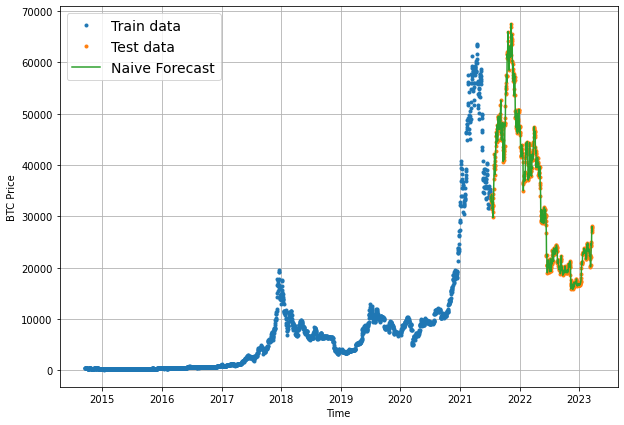

In [19]:
# plot the naive forecast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive Forecast");

Let's zoom it and only plot the test and naive forecast


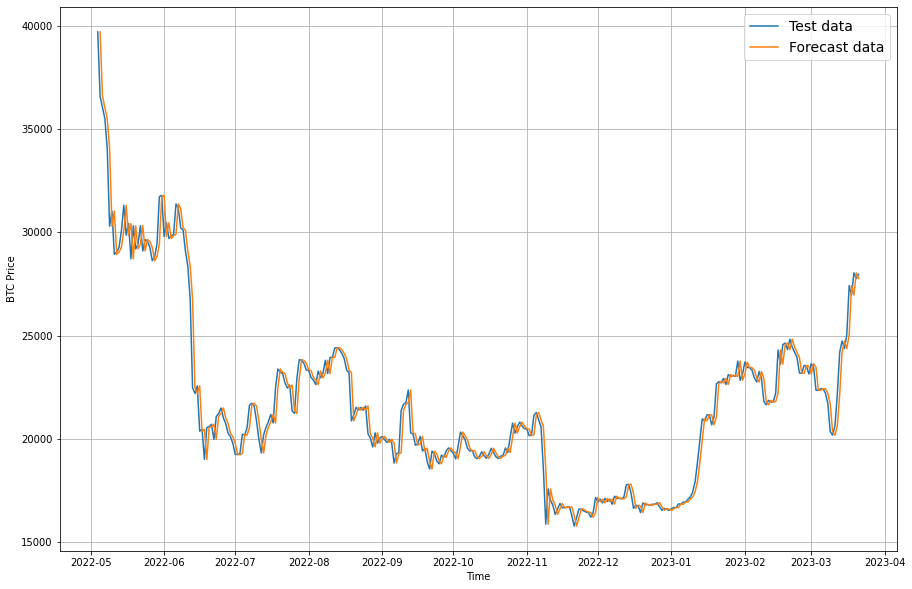

In [20]:
plt.figure(figsize=(15,10))
offset=300
plot_time_series(timesteps=X_test, values=y_test, start=offset, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=offset, format="-", label="Forecast data");

When we zoom in we see the naive forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

Forecast made. Time to evaluate it.

## Evaluating a Time series model

Time series problem is often involves predicting a number which is the same output as Regression model, so we can similar types of metrics to evaluate Time series model, but let's see what are they, but thing to note for all the metrics, **lower the better** (for example an MAE of 0 is better than MAE 100).

### Scale Dependent Errors

These are metrics which can be used to compare time series values and forecasts which are in same scale.

for example, predicting the price of Bitcoin using historical prices in USD versus forecasting values in USD

| Metric | Details | Code |
| ------ |------ |------ |
| MAE (mean absolute error) |Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median | `tf.keras.metrics.mean_absolute_error()` |
| RMSE (root mean squared error) | Forecasts which minimises the RMSE lead to forecasts of the mean | `tf.sqrt(tf.keras.metrics.mean_square_error())` |

### Percentage Errors

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

| Metric | Details | Code |
| ---- | ---- | ---- |
| MAPE (mean absolute percentage error) | Most commonly used precentage error. May explode (not work) if `y=0` | `tf.keras.metrics.mean_absolute_percentage_error()` |
| sMAPE (symmetric mean absolute percentage error) | Recommended not to be used by [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors), though it is used in forecasting competitions | Custom implementation |


### Scaled Errors

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

| Metric | Details | Code |
| ---- | ---- | ---- |
| MASE (mean absolute scaled error) | MASE equals one of the naive forecast (or very close to one). A forecast which performs better than the naive should get < 1 MASE | See sktime's, [`mase_loss`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |


### Creating our own MASE function

We'll take inspiration from [sktime's](https://github.com/alan-turing-institute/sktime)(Scikit-Learn for time series) `MeanAbsoluteScaledError` class which calculates the MASE.
                                                                                                                          
                                                                                                                                                                                                                                                    


In [21]:
import tensorflow as tf

In [22]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true, y_pred))

  naive_mae_no_seasonality = tf.reduce_mean(tf.abs(y_true[1:], y_true[:-1]))

  return mae / naive_mae_no_seasonality

Let's put each of our different evaluation metrics together into a function.

In [23]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [24]:
naive_results = evaluate_preds(y_test[1:],
                               naive_forecast)

naive_results

{'mae': 807.27057,
 'mse': 1472736.0,
 'rmse': 1213.5634,
 'mape': 2.3311722,
 'mase': 1.0000142}

Alright, this will be our baseline results to beat in further modelling experiment.

So if we look into `mae` result, it's `807.27` it means that each prediction in the naive forecast is off by **$807**

## Other kinds of time series forecasting models which can be used for baselines and actual forecasts

| Model/Library Name |	Resource |
| ---- | ---- |
| Moving average |	https://machinelearningmastery.com/ moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) |	https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) |	https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) |	https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) |	https://github.com/facebookresearch/Kats |
| LinkedIn Greykite (flexible, intuitive and fast forecasts) |	https://github.com/linkedin/greykite |

## Format Data Part 2: Windowing dataset

We've got to window our time series.

Why do we window ?

Windowing is a method to turn a time series dataset into **supervised learning problem.**

In other words, we want to use windows of the past to predict the future.

For example, for a univariate time series, windowing for one week (window=7) to predict the next single value(horizon=1) might look like:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

Similarly the price of Bitcoin look like,

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

Let's build some functions which take in a univariate time series and turn it into windows and horizons of specified sizes.

We'll start with the default horizon size of 1 and a window size of 7 (these aren't necessarily the best values to use, these are just randomly picked)

In [25]:
HORIZON = 1
WINDOW_SIZE = 7

In [26]:
# Create a function which takes an array as input and return it in form of window and horizon
def get_labelled_windows(x, horizon=1):
  """
  Create labels for windowed dataset

  E.g if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6, 7] -> Output: ([1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [27]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)

print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


Now we can do the same thing with entire time series data through Python loops, but to make things faster we can use [Numpy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).


Let's write a function which:

1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses Numpy indexing to create a 2D of multiple window steps, for example:

```
[0, 1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7]
[2, 3, 4, 5, 6, 7, 8]
```
3. Uses the 2D array of multiple window steps to index on a target series.
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon.




In [28]:
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """

  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  #print(f"window_step: \n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  #print(f"Window indexes: \n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

Let's try with bitcoin prices

In [29]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3101, 3101)

In [30]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]} ")

Window: [457.334015 424.440002 394.79599  408.903992 398.821014 402.152008
 435.790985] -> Label: [423.204987] 
Window: [424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987] -> Label: [411.574005] 
Window: [394.79599  408.903992 398.821014 402.152008 435.790985 423.204987
 411.574005] -> Label: [404.424988] 


In [31]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]} ")

Window: [22163.949219 24197.533203 24746.074219 24375.960938 25052.789063
 27423.929688 26965.878906] -> Label: [28038.675781] 
Window: [24197.533203 24746.074219 24375.960938 25052.789063 27423.929688
 26965.878906 28038.675781] -> Label: [27767.236328] 
Window: [24746.074219 24375.960938 25052.789063 27423.929688 26965.878906
 28038.675781 27767.236328] -> Label: [27964.888672] 


Anyways, we have written the whole function but this can also be achieved using [tf.keras.preprocessing.timeseries_dataset_from_array()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array)

### Turning windows into Training and Test sets



In [32]:
# Make the train and test split
def make_train_test_split(windows, labels, test_split=0.2):

  split_size=int(len(windows) * (1-test_split)) # this will be default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [33]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2480, 621, 2480, 621)

In [34]:
train_windows[:5], train_labels[:5]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005],
        [408.903992, 398.821014, 402.152008, 435.790985, 423.204987,
         411.574005, 404.424988],
        [398.821014, 402.152008, 435.790985, 423.204987, 411.574005,
         404.424988, 399.519989]]), array([[423.204987],
        [411.574005],
        [404.424988],
        [399.519989],
        [377.181   ]]))

## Creating a Model Checkpoint

For a fair comparison between all the models that we're going to build, we need to train it with equal amount of epochs let's say 100 and then store the best performing model during training so that we can compare with the best performing model.

This can be possible using `ModelCheckpoint`.

`ModelCheckpoint` callback will monitor our model's performance during training and save the best model to the file by setting `save_best_only=True`


In [35]:
import os

def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor='val_loss',
                                            verbose=0,
                                            save_best_only=True)

## Model 1: Dense model (window=7, horizon=1)

We're going to start by keeping it simple, `model_1` will have:
- A single dense layer with 128 hidden units and reLu activation
- An output layer with linear activation
- Adam optimizer and MAE, MSE metrics
- Batch size of 128

In [36]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(17)

# Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], name='model_1_dense')


# compile the model
model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

# fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
16/20 [=======================>......] - ETA: 0s - loss: 3075.3787 - mae: 3075.3787 

20/20 [==============================] - 3s 49ms/step - loss: 2792.0408 - mae: 2792.0408 - val_loss: 4794.1250 - val_mae: 4794.1250
Epoch 2/100
 1/20 [>.............................] - ETA: 0s - loss: 1225.9572 - mae: 1225.9572

20/20 [==============================] - 1s 28ms/step - loss: 554.8013 - mae: 554.8013 - val_loss: 1701.2377 - val_mae: 1701.2377
Epoch 3/100
 1/20 [>.............................] - ETA: 0s - loss: 428.8914 - mae: 428.8914

20/20 [==============================] - 1s 30ms/step - loss: 401.9747 - mae: 401.9747 - val_loss: 1229.3822 - val_mae: 1229.3822
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 373.9146 - mae: 373.9146 - val_loss: 1284.2684 - val_mae: 1284.2684
Epoch 5/100
 1/20 [>.............................] - ETA: 0s - loss: 384.3762 - mae: 384.3762

20/20 [==============================] - 1s 29ms/step - loss: 358.1997 - mae: 358.1997 - val_loss: 1125.5559 - val_mae: 1125.5559
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 347.5406 - mae: 347.5406 - val_loss: 1144.4171 - val_mae: 1144.4171
Epoch 7/100
 1/20 [>.............................] - ETA: 0s - loss: 251.8529 - mae: 251.8529

20/20 [==============================] - 1s 29ms/step - loss: 340.6719 - mae: 340.6719 - val_loss: 1112.8455 - val_mae: 1112.8455
Epoch 8/100
20/20 [==============================] - 0s 4ms/step - loss: 364.6488 - mae: 364.6488 - val_loss: 1473.0177 - val_mae: 1473.0177
Epoch 9/100
 1/20 [>.............................] - ETA: 0s - loss: 399.8143 - mae: 399.8143

20/20 [==============================] - 1s 30ms/step - loss: 370.5804 - mae: 370.5804 - val_loss: 1062.8317 - val_mae: 1062.8317
Epoch 10/100
 1/20 [>.............................] - ETA: 0s - loss: 344.9001 - mae: 344.9001

20/20 [==============================] - 1s 28ms/step - loss: 324.9841 - mae: 324.9841 - val_loss: 1001.0076 - val_mae: 1001.0076
Epoch 11/100
 1/20 [>.............................] - ETA: 0s - loss: 315.7524 - mae: 315.7524

20/20 [==============================] - 1s 35ms/step - loss: 305.1688 - mae: 305.1688 - val_loss: 981.3586 - val_mae: 981.3586
Epoch 12/100
20/20 [==============================] - ETA: 0s - loss: 295.9417 - mae: 295.9417

20/20 [==============================] - 1s 44ms/step - loss: 295.9417 - mae: 295.9417 - val_loss: 965.5303 - val_mae: 965.5303
Epoch 13/100
20/20 [==============================] - 0s 6ms/step - loss: 297.5267 - mae: 297.5267 - val_loss: 990.4755 - val_mae: 990.4755
Epoch 14/100
20/20 [==============================] - 0s 6ms/step - loss: 285.1145 - mae: 285.1145 - val_loss: 1015.7390 - val_mae: 1015.7390
Epoch 15/100
14/20 [====================>.........] - ETA: 0s - loss: 285.7958 - mae: 285.7958

20/20 [==============================] - 1s 49ms/step - loss: 289.1274 - mae: 289.1274 - val_loss: 922.5135 - val_mae: 922.5135
Epoch 16/100
20/20 [==============================] - 0s 6ms/step - loss: 287.8987 - mae: 287.8987 - val_loss: 942.0019 - val_mae: 942.0019
Epoch 17/100
20/20 [==============================] - 0s 5ms/step - loss: 290.1082 - mae: 290.1082 - val_loss: 1143.7056 - val_mae: 1143.7056
Epoch 18/100
20/20 [==============================] - 0s 4ms/step - loss: 284.3640 - mae: 284.3640 - val_loss: 1074.7231 - val_mae: 1074.7231
Epoch 19/100
 1/20 [>.............................] - ETA: 0s - loss: 289.1939 - mae: 289.1939

20/20 [==============================] - 1s 29ms/step - loss: 299.7598 - mae: 299.7598 - val_loss: 910.2131 - val_mae: 910.2131
Epoch 20/100
20/20 [==============================] - 0s 4ms/step - loss: 283.8050 - mae: 283.8050 - val_loss: 952.1508 - val_mae: 952.1508
Epoch 21/100
20/20 [==============================] - 0s 4ms/step - loss: 280.1705 - mae: 280.1705 - val_loss: 926.1161 - val_mae: 926.1161
Epoch 22/100
20/20 [==============================] - 0s 4ms/step - loss: 283.4040 - mae: 283.4040 - val_loss: 985.7353 - val_mae: 985.7353
Epoch 23/100
20/20 [==============================] - 0s 5ms/step - loss: 283.7202 - mae: 283.7202 - val_loss: 1131.5374 - val_mae: 1131.5374
Epoch 24/100
20/20 [==============================] - 0s 4ms/step - loss: 293.4020 - mae: 293.4020 - val_loss: 947.9409 - val_mae: 947.9409
Epoch 25/100
20/20 [==============================] - 0s 5ms/step - loss: 287.8166 - mae: 287.8166 - val_loss: 946.2331 - val_mae: 946.2331
Epoch 26/100
20/20 [==========

20/20 [==============================] - 1s 48ms/step - loss: 267.3923 - mae: 267.3923 - val_loss: 888.1571 - val_mae: 888.1571
Epoch 30/100
20/20 [==============================] - 0s 4ms/step - loss: 272.6445 - mae: 272.6445 - val_loss: 907.3746 - val_mae: 907.3746
Epoch 31/100
20/20 [==============================] - 0s 4ms/step - loss: 276.4685 - mae: 276.4685 - val_loss: 912.2150 - val_mae: 912.2150
Epoch 32/100
20/20 [==============================] - 0s 4ms/step - loss: 265.1555 - mae: 265.1555 - val_loss: 934.6793 - val_mae: 934.6793
Epoch 33/100
 1/20 [>.............................] - ETA: 0s - loss: 199.9102 - mae: 199.9102

20/20 [==============================] - 1s 29ms/step - loss: 266.9358 - mae: 266.9358 - val_loss: 879.2613 - val_mae: 879.2613
Epoch 34/100
20/20 [==============================] - 0s 4ms/step - loss: 263.9115 - mae: 263.9115 - val_loss: 895.7492 - val_mae: 895.7492
Epoch 35/100
20/20 [==============================] - 0s 5ms/step - loss: 277.5984 - mae: 277.5984 - val_loss: 965.1630 - val_mae: 965.1630
Epoch 36/100
 1/20 [>.............................] - ETA: 0s - loss: 274.2425 - mae: 274.2425

20/20 [==============================] - 1s 30ms/step - loss: 275.4336 - mae: 275.4336 - val_loss: 875.9457 - val_mae: 875.9457
Epoch 37/100
20/20 [==============================] - 0s 4ms/step - loss: 276.2012 - mae: 276.2012 - val_loss: 877.7433 - val_mae: 877.7433
Epoch 38/100
20/20 [==============================] - 0s 4ms/step - loss: 278.6145 - mae: 278.6145 - val_loss: 948.5161 - val_mae: 948.5161
Epoch 39/100
20/20 [==============================] - 0s 4ms/step - loss: 288.0308 - mae: 288.0308 - val_loss: 884.9558 - val_mae: 884.9558
Epoch 40/100
20/20 [==============================] - 0s 4ms/step - loss: 297.8834 - mae: 297.8834 - val_loss: 1067.2047 - val_mae: 1067.2047
Epoch 41/100
 1/20 [>.............................] - ETA: 0s - loss: 264.8150 - mae: 264.8150

20/20 [==============================] - 1s 29ms/step - loss: 292.1719 - mae: 292.1719 - val_loss: 863.5980 - val_mae: 863.5980
Epoch 42/100
20/20 [==============================] - 0s 4ms/step - loss: 262.7744 - mae: 262.7744 - val_loss: 959.9930 - val_mae: 959.9930
Epoch 43/100
20/20 [==============================] - 0s 4ms/step - loss: 269.7375 - mae: 269.7375 - val_loss: 907.4795 - val_mae: 907.4795
Epoch 44/100
20/20 [==============================] - 0s 4ms/step - loss: 267.2983 - mae: 267.2983 - val_loss: 940.7028 - val_mae: 940.7028
Epoch 45/100
20/20 [==============================] - 0s 5ms/step - loss: 282.5662 - mae: 282.5662 - val_loss: 865.4006 - val_mae: 865.4006
Epoch 46/100
 1/20 [>.............................] - ETA: 0s - loss: 232.3741 - mae: 232.3741

20/20 [==============================] - 1s 31ms/step - loss: 272.2120 - mae: 272.2120 - val_loss: 863.0887 - val_mae: 863.0887
Epoch 47/100
20/20 [==============================] - 0s 5ms/step - loss: 261.0833 - mae: 261.0833 - val_loss: 868.0747 - val_mae: 868.0747
Epoch 48/100
 1/20 [>.............................] - ETA: 0s - loss: 251.1825 - mae: 251.1825

20/20 [==============================] - 1s 30ms/step - loss: 263.9590 - mae: 263.9590 - val_loss: 856.5920 - val_mae: 856.5920
Epoch 49/100
20/20 [==============================] - 0s 4ms/step - loss: 268.0483 - mae: 268.0483 - val_loss: 858.0887 - val_mae: 858.0887
Epoch 50/100
 1/20 [>.............................] - ETA: 0s - loss: 369.4937 - mae: 369.4937

20/20 [==============================] - 1s 29ms/step - loss: 256.8866 - mae: 256.8866 - val_loss: 853.9896 - val_mae: 853.9896
Epoch 51/100
20/20 [==============================] - 0s 4ms/step - loss: 261.5140 - mae: 261.5140 - val_loss: 855.7652 - val_mae: 855.7652
Epoch 52/100
20/20 [==============================] - 0s 5ms/step - loss: 261.1118 - mae: 261.1118 - val_loss: 865.7687 - val_mae: 865.7687
Epoch 53/100
20/20 [==============================] - ETA: 0s - loss: 259.0066 - mae: 259.0066

20/20 [==============================] - 1s 30ms/step - loss: 259.0066 - mae: 259.0066 - val_loss: 853.7353 - val_mae: 853.7353
Epoch 54/100
20/20 [==============================] - 0s 5ms/step - loss: 267.7487 - mae: 267.7487 - val_loss: 865.8911 - val_mae: 865.8911
Epoch 55/100
20/20 [==============================] - 0s 4ms/step - loss: 266.1386 - mae: 266.1386 - val_loss: 923.4431 - val_mae: 923.4431
Epoch 56/100
20/20 [==============================] - 0s 4ms/step - loss: 277.1724 - mae: 277.1724 - val_loss: 887.3196 - val_mae: 887.3196
Epoch 57/100
20/20 [==============================] - 0s 4ms/step - loss: 266.8858 - mae: 266.8858 - val_loss: 877.3494 - val_mae: 877.3494
Epoch 58/100
20/20 [==============================] - 0s 4ms/step - loss: 270.4533 - mae: 270.4533 - val_loss: 898.4073 - val_mae: 898.4073
Epoch 59/100
 1/20 [>.............................] - ETA: 0s - loss: 282.3931 - mae: 282.3931

20/20 [==============================] - 1s 30ms/step - loss: 257.2463 - mae: 257.2463 - val_loss: 844.9999 - val_mae: 844.9999
Epoch 60/100
20/20 [==============================] - 0s 4ms/step - loss: 259.1847 - mae: 259.1847 - val_loss: 847.6960 - val_mae: 847.6960
Epoch 61/100
20/20 [==============================] - 0s 5ms/step - loss: 281.7926 - mae: 281.7926 - val_loss: 846.0903 - val_mae: 846.0903
Epoch 62/100
20/20 [==============================] - 0s 4ms/step - loss: 272.6345 - mae: 272.6345 - val_loss: 1103.8669 - val_mae: 1103.8669
Epoch 63/100
20/20 [==============================] - 0s 4ms/step - loss: 281.3657 - mae: 281.3657 - val_loss: 897.7329 - val_mae: 897.7329
Epoch 64/100
 1/20 [>.............................] - ETA: 0s - loss: 257.5106 - mae: 257.5106

20/20 [==============================] - 1s 34ms/step - loss: 281.7397 - mae: 281.7397 - val_loss: 840.1794 - val_mae: 840.1794
Epoch 65/100
20/20 [==============================] - 0s 6ms/step - loss: 269.6046 - mae: 269.6046 - val_loss: 853.9977 - val_mae: 853.9977
Epoch 66/100
20/20 [==============================] - 0s 6ms/step - loss: 262.5562 - mae: 262.5562 - val_loss: 866.1940 - val_mae: 866.1940
Epoch 67/100
20/20 [==============================] - 0s 7ms/step - loss: 298.2773 - mae: 298.2773 - val_loss: 1189.2393 - val_mae: 1189.2393
Epoch 68/100
19/20 [===========================>..] - ETA: 0s - loss: 259.5374 - mae: 259.5374

20/20 [==============================] - 1s 43ms/step - loss: 260.9642 - mae: 260.9642 - val_loss: 839.6727 - val_mae: 839.6727
Epoch 69/100
20/20 [==============================] - 0s 5ms/step - loss: 261.6268 - mae: 261.6268 - val_loss: 991.4343 - val_mae: 991.4343
Epoch 70/100
20/20 [==============================] - 0s 5ms/step - loss: 273.8913 - mae: 273.8913 - val_loss: 883.6750 - val_mae: 883.6750
Epoch 71/100
 1/20 [>.............................] - ETA: 0s - loss: 207.3788 - mae: 207.3788

20/20 [==============================] - 1s 43ms/step - loss: 264.3339 - mae: 264.3339 - val_loss: 835.9741 - val_mae: 835.9741
Epoch 72/100
20/20 [==============================] - 0s 6ms/step - loss: 260.2310 - mae: 260.2310 - val_loss: 1202.8030 - val_mae: 1202.8030
Epoch 73/100
20/20 [==============================] - 0s 4ms/step - loss: 296.2088 - mae: 296.2088 - val_loss: 918.3803 - val_mae: 918.3803
Epoch 74/100
20/20 [==============================] - 0s 5ms/step - loss: 259.1826 - mae: 259.1826 - val_loss: 1033.4587 - val_mae: 1033.4587
Epoch 75/100
20/20 [==============================] - 0s 4ms/step - loss: 266.0799 - mae: 266.0799 - val_loss: 961.0803 - val_mae: 961.0803
Epoch 76/100
20/20 [==============================] - 0s 4ms/step - loss: 260.0511 - mae: 260.0511 - val_loss: 841.4428 - val_mae: 841.4428
Epoch 77/100
 1/20 [>.............................] - ETA: 0s - loss: 299.8536 - mae: 299.8536

20/20 [==============================] - 1s 29ms/step - loss: 262.3962 - mae: 262.3962 - val_loss: 830.8629 - val_mae: 830.8629
Epoch 78/100
20/20 [==============================] - 0s 3ms/step - loss: 267.7140 - mae: 267.7140 - val_loss: 967.3462 - val_mae: 967.3462
Epoch 79/100
20/20 [==============================] - 0s 4ms/step - loss: 261.2122 - mae: 261.2122 - val_loss: 843.1080 - val_mae: 843.1080
Epoch 80/100
20/20 [==============================] - 0s 4ms/step - loss: 264.0167 - mae: 264.0167 - val_loss: 946.0837 - val_mae: 946.0837
Epoch 81/100
20/20 [==============================] - 0s 5ms/step - loss: 258.2359 - mae: 258.2359 - val_loss: 851.7524 - val_mae: 851.7524
Epoch 82/100
20/20 [==============================] - 0s 4ms/step - loss: 293.3842 - mae: 293.3842 - val_loss: 1625.8699 - val_mae: 1625.8699
Epoch 83/100
20/20 [==============================] - 0s 4ms/step - loss: 294.1900 - mae: 294.1900 - val_loss: 1058.4854 - val_mae: 1058.4854
Epoch 84/100
20/20 [========

20/20 [==============================] - 1s 31ms/step - loss: 258.2780 - mae: 258.2780 - val_loss: 828.6740 - val_mae: 828.6740
Epoch 92/100
20/20 [==============================] - 0s 4ms/step - loss: 254.1832 - mae: 254.1832 - val_loss: 857.9924 - val_mae: 857.9924
Epoch 93/100
20/20 [==============================] - 0s 5ms/step - loss: 257.3689 - mae: 257.3689 - val_loss: 832.1099 - val_mae: 832.1099
Epoch 94/100
20/20 [==============================] - 0s 4ms/step - loss: 257.3979 - mae: 257.3979 - val_loss: 952.9048 - val_mae: 952.9048
Epoch 95/100
20/20 [==============================] - 0s 4ms/step - loss: 268.3119 - mae: 268.3119 - val_loss: 952.3339 - val_mae: 952.3339
Epoch 96/100
20/20 [==============================] - 0s 4ms/step - loss: 265.1045 - mae: 265.1045 - val_loss: 1106.0624 - val_mae: 1106.0624
Epoch 97/100
20/20 [==============================] - 0s 4ms/step - loss: 284.5622 - mae: 284.5622 - val_loss: 882.0844 - val_mae: 882.0844
Epoch 98/100
20/20 [==========

In [37]:
# evaluate the model
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 868.7023 - mae: 868.7023


[868.7022705078125, 868.7022705078125]

This is the last epoch's evaluation results, but let's check the best model weights

In [38]:
model_1 = tf.keras.models.load_model('model_experiments/model_1_dense')
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 828.6741 - mae: 828.6741


[828.674072265625, 828.674072265625]

Okay, not bad but what about the predictions on `model_1`. Let's create a function to make predictions and then evaluate the results of model_1 on those predictions.

### Make Prediction function

In [39]:
def make_predictions(model, input_data):
  """
  Returns the prediction result on input_data for the model passed.
  """
  y_preds = model.predict(input_data)
  return tf.squeeze(y_preds) # returns 1D array of predictions

In [40]:
model_1_preds = make_predictions(model_1, test_windows)
model_1_preds[:10]

20/20 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([33086.023, 33581.656, 33597.797, 34196.43 , 33390.637, 32802.797,
       32781.12 , 31965.47 , 31421.764, 31435.463], dtype=float32)>

In [42]:
test_labels.shape, model_1_preds.shape

((621, 1), TensorShape([621]))

In [43]:
# evaluate results
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)
model_1_results

{'mae': 828.674,
 'mse': 1555389.8,
 'rmse': 1247.1527,
 'mape': 2.4015195,
 'mase': 1.0000142}

In [44]:
# view the naive results
naive_results

{'mae': 807.27057,
 'mse': 1472736.0,
 'rmse': 1213.5634,
 'mape': 2.3311722,
 'mase': 1.0000142}

Naive model results (baseline) is beating our first dense model(model_1) but that's expected. Let's do further visualization by plotting the prediction in the graph.

### Plot `model_1` results

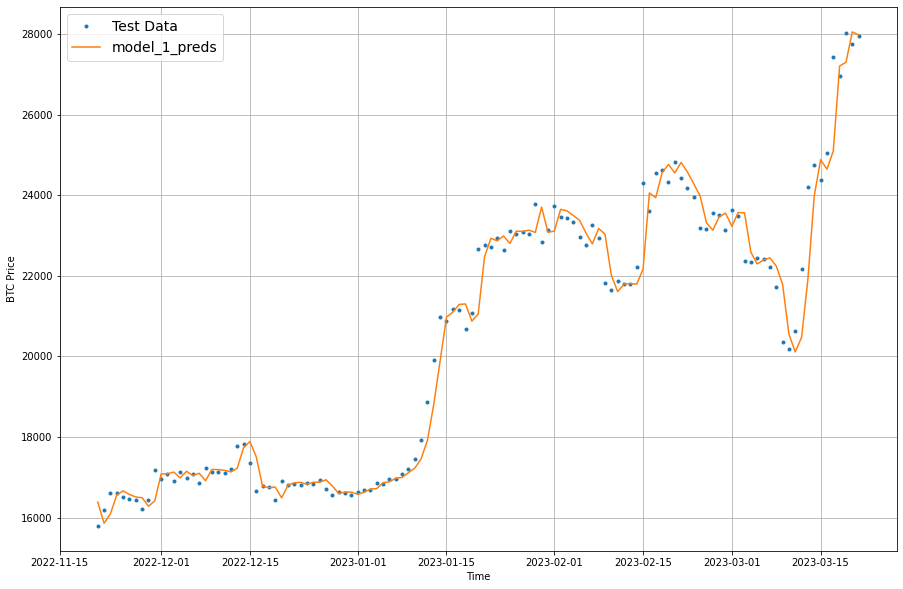

In [52]:
offset = 500
plt.figure(figsize=(15, 10))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-",label="model_1_preds")

Something wrong with the predictions ?

Since they're on the test dataset. So they're not actual forecasts.

With our current model setup, we've to make forecasts for the future.